In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!pwd

/content


In [ ]:
cd /content/gdrive/MyDrive/BacteriaSegmentation

/content/gdrive/MyDrive/BacteriaSegmentation


In [ ]:
!pwd

/content/gdrive/MyDrive/BacteriaSegmentation


In [ ]:
!ls /content/gdrive/MyDrive/BacteriaSegmentation

data  model1.png  model3_new.png  model4_new.png  model.ipynb  saved_model


In [ ]:
!ls /content/gdrive/MyDrive/BacteriaSegmentation/data

dataForModel  encodedMasks  images  masks  meta.json


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread

%matplotlib inline
from PIL import Image
import PIL
import cv2
import os
from tqdm import tqdm
import tensorflow as tf
#import random



from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [ ]:
IMG_WIDTH = 128
IMG_HEIGHT = 128
CHANNELS = 3

BATCH_SIZE = 16

In [ ]:
IMG_PATH = 'data/images/'
MASK_PATH = 'data/masks/'
MASK_HOT_ENCODING_PATH = 'data/encodedMasks/'
MASKS = '/content/gdrive/MyDrive/BacteriaSegmentation/data/dataForModel/encodedMasks'
IMAGES = '/content/gdrive/MyDrive/BacteriaSegmentation/data/dataForModel/images'

In [ ]:
# plotting the loss
def plot_loss(history):
  plt.plot(history.history['loss'], label='train loss')
  plt.plot(history.history['val_loss'], label='val loss')
  plt.legend()
  plt.show()

# plotting the accuracy
def plot_accuracy(history):
  plt.plot(history.history['accuracy'], label='train acc')
  plt.plot(history.history['val_accuracy'], label='val acc')
  plt.legend()
  plt.show()

def diagnose_plots(history):
  plot_loss(history)
  plot_accuracy(history)

In [ ]:

np.random.seed(42)

In [ ]:
#random.seed(42)

In [ ]:
train_image_datagen = ImageDataGenerator(
    rotation_range=0.5,
    width_shift_range=0.3,
    shear_range = 0.2,
    height_shift_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.2,
    validation_split=0.25
    
)

train_label_datagen = ImageDataGenerator(
    rotation_range=0.5,
    width_shift_range=0.3,
    shear_range = 0.2,
    height_shift_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.2,
    validation_split=0.25

)

seed = 42
#train_image_datagen.fit(IMAGES, augment=True, seed=seed)
#train_label_datagen.fit(MASKS, augment=True, seed=seed)

training_image_generator = train_image_datagen.flow_from_directory(
    IMAGES,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode=None,
    subset='training',
    batch_size=BATCH_SIZE ,
    seed=seed
)
training_label_generator = train_image_datagen.flow_from_directory(
    MASKS,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode=None,
    subset='training',
    batch_size=BATCH_SIZE ,
    seed=seed
)


validation_image_generator = train_image_datagen.flow_from_directory(
    IMAGES,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode=None,
    subset='validation',
    batch_size=BATCH_SIZE ,
    seed=seed
    
)
validation_label_generator = train_image_datagen.flow_from_directory(
    MASKS,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode=None,
    subset='validation',
    batch_size=BATCH_SIZE ,
    seed=seed
   
)

training_generator = zip(training_image_generator, training_label_generator)
validation_generator = zip(validation_image_generator, validation_label_generator)

Found 275 images belonging to 1 classes.
Found 275 images belonging to 1 classes.
Found 91 images belonging to 1 classes.
Found 91 images belonging to 1 classes.


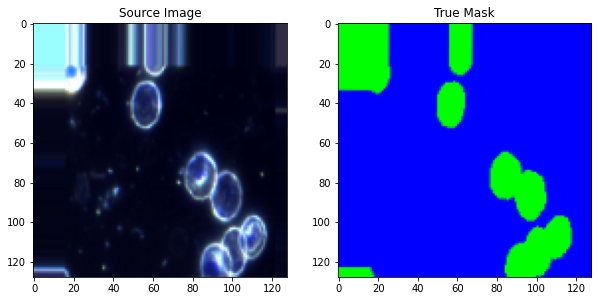

In [ ]:
testIMG, labels = training_generator.__next__()
	
figure = plt.figure(figsize=(10,10))

plt.subplot(1,2,1)
plt.title('Source Image')
plt.imshow(testIMG[0]/255.)

plt.subplot(1,2,2)
plt.title('True Mask')
plt.imshow(labels[0])


plt.show()

In [ ]:
# Model Architecture

inputs1 = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, CHANNELS))
x = tf.keras.layers.Lambda(lambda x: x / 255)(inputs1)
#high to low
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
#c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
#c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
 
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
#c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
 
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
#c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
 
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
#c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#low to high
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
#c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
 
u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
#c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
 
u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
#c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
 
u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
#c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
 
outputs1 = tf.keras.layers.Conv2D(3, (1, 1), activation='softmax')(c9)


In [ ]:
model1 = tf.keras.Model(inputs=[inputs1], outputs=[outputs1])
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model1.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 128, 128, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 128, 128, 16) 448         lambda_1[0][0]                   
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, 128, 128, 16) 2320        conv2d_10[0][0]                  
____________________________________________________________________________________________

In [ ]:
# Uncomment to draw model graph
# Graph already saved as model1.png

#tf.keras.utils.plot_model(model1, to_file='model1_new.png', show_shapes=True)

In [ ]:
checkpoints = tf.keras.callbacks.ModelCheckpoint('saved_model/model1_ES.h5', verbose=1, save_best_only=True)

callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss')]

In [ ]:
history1 = model1.fit_generator(training_generator,
                          epochs=10,
                          steps_per_epoch = 100,
                          validation_data=validation_generator,
                          validation_steps=10,
                          callbacks = callbacks)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
100/100 [==============================] - 45s 435ms/step - loss: 0.6107 - accuracy: 0.8028 - val_loss: 0.2552 - val_accuracy: 0.9371
Epoch 2/10
100/100 [==============================] - 42s 423ms/step - loss: 0.2707 - accuracy: 0.9039 - val_loss: 0.2222 - val_accuracy: 0.9425
Epoch 3/10
100/100 [==============================] - 43s 430ms/step - loss: 0.2588 - accuracy: 0.9115 - val_loss: 0.2213 - val_accuracy: 0.9397
Epoch 4/10
100/100 [==============================] - 43s 430ms/step - loss: 0.2281 - accuracy: 0.9261 - val_loss: 0.2332 - val_accuracy: 0.9324
Epoch 5/10
100/100 [==============================] - 42s 426ms/step - loss: 0.2273 - accuracy: 0.9291 - val_loss: 0.2596 - val_accuracy: 0.9210


In [ ]:
model1.save("saved_model/model1.h5")

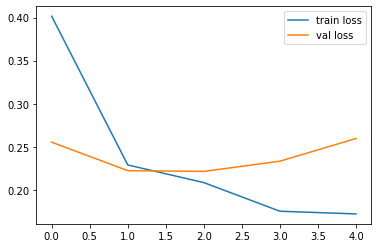

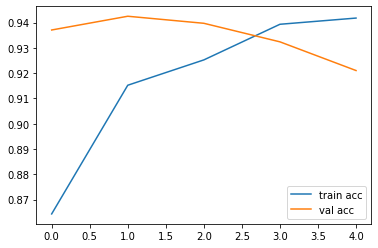

In [ ]:
diagnose_plots(history1)

In [ ]:
_, accuracy1 = model1.evaluate_generator(validation_generator, steps=30, verbose=0)
accuracy1

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


0.9329489469528198

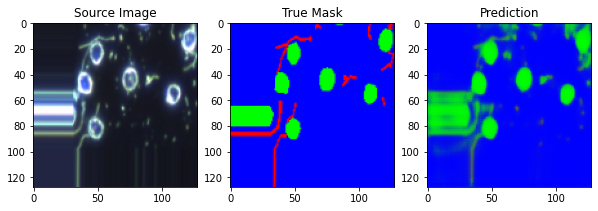

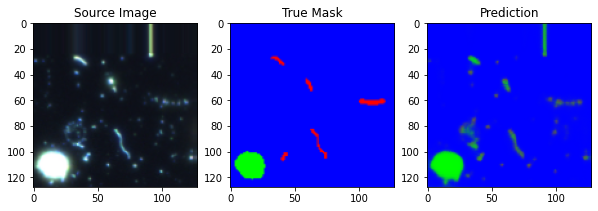

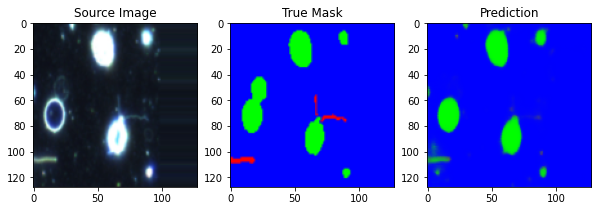

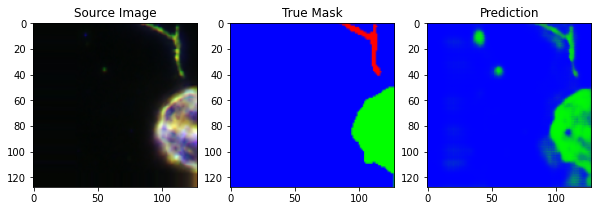

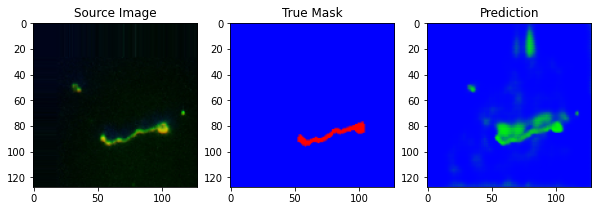

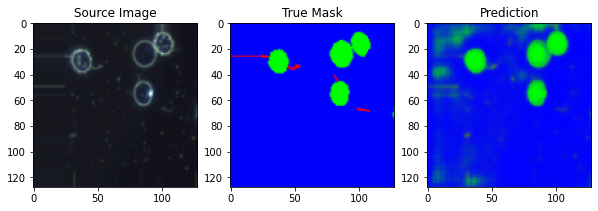

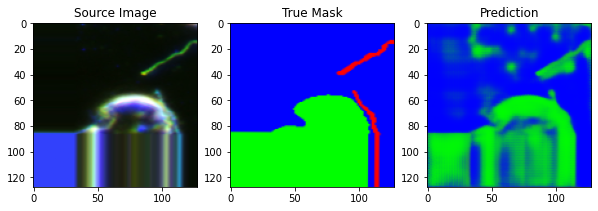

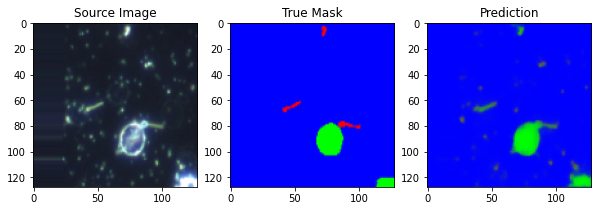

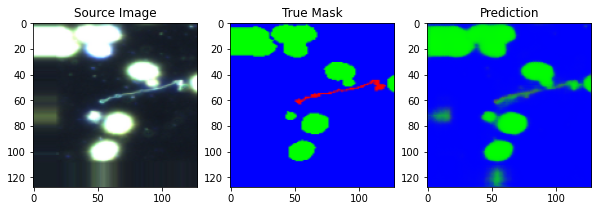

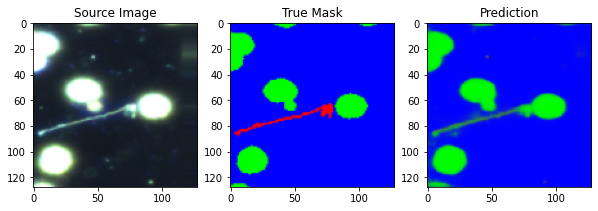

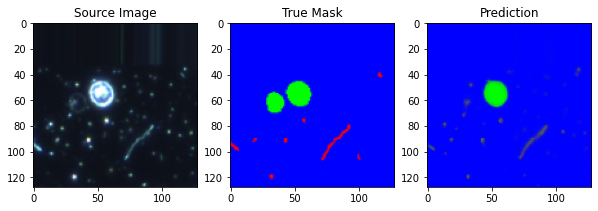

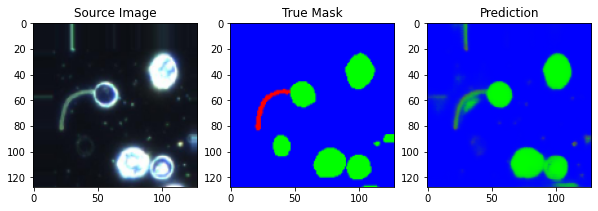

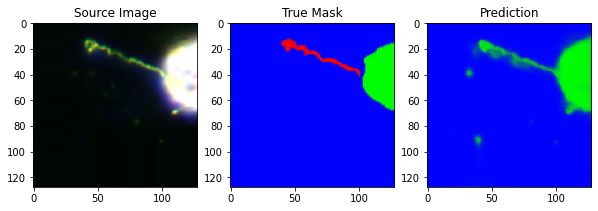

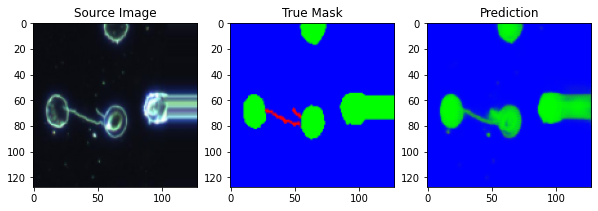

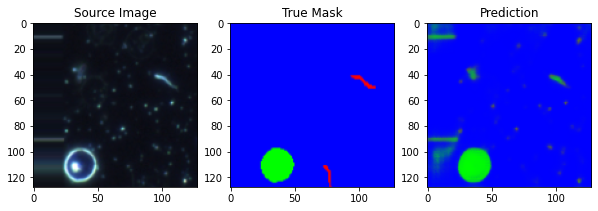

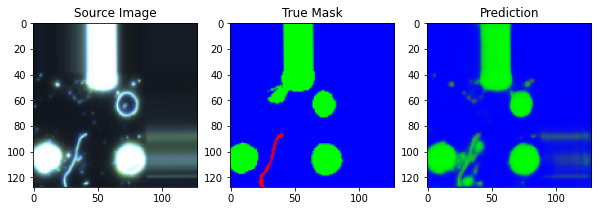

In [ ]:
testIMG, labels = validation_generator.__next__()
predictions = model1.predict(testIMG, use_multiprocessing=False)

for i in range(len(predictions)):
	
	figure = plt.figure(figsize=(10,10))

	plt.subplot(1,3,1)
	plt.title('Source Image')
	plt.imshow(testIMG[i] / 255)

	plt.subplot(1,3,2)
	plt.title('True Mask')
	plt.imshow(labels[i])


	plt.subplot(1,3,3)
	plt.title('Prediction')
	plt.imshow(predictions[i])

plt.show()




In [ ]:
# without callback

model2 = tf.keras.Model(inputs=[inputs1], outputs=[outputs1])
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model2.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 128, 128, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 128, 128, 16) 448         lambda_1[0][0]                   
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, 128, 128, 16) 2320        conv2d_10[0][0]                  
____________________________________________________________________________________________

In [ ]:
# Uncomment to draw model2 graph

#tf.keras.utils.plot_model(model1, to_file='model2_new.png', show_shapes=True)

In [ ]:
# without callback
history2 = model2.fit_generator(training_generator,
                          epochs=10,
                          steps_per_epoch = 100,
                          validation_data=validation_generator,
                          validation_steps=10)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
100/100 [==============================] - 44s 430ms/step - loss: 0.1993 - accuracy: 0.9379 - val_loss: 0.2227 - val_accuracy: 0.9399
Epoch 2/10
100/100 [==============================] - 42s 423ms/step - loss: 0.2072 - accuracy: 0.9352 - val_loss: 0.2118 - val_accuracy: 0.9471
Epoch 3/10
100/100 [==============================] - 42s 427ms/step - loss: 0.1980 - accuracy: 0.9418 - val_loss: 0.1884 - val_accuracy: 0.9463
Epoch 4/10
100/100 [==============================] - 42s 425ms/step - loss: 0.1617 - accuracy: 0.9516 - val_loss: 0.2373 - val_accuracy: 0.9355
Epoch 5/10
100/100 [==============================] - 42s 425ms/step - loss: 0.2126 - accuracy: 0.9398 - val_loss: 0.2001 - val_accuracy: 0.9479
Epoch 6/10
100/100 [==============================] - 42s 425ms/step - loss: 0.1989 - accuracy: 0.9436 - val_loss: 0.1980 - val_accuracy: 0.9476
Epoch 7/10
100/100 [==============================] - 42s 427ms/step - loss: 0.1890 - accuracy: 0.9450 - val_loss: 0.2033 - val_ac

In [ ]:
model2.save("saved_model/model2.h5")

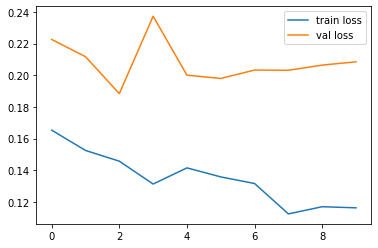

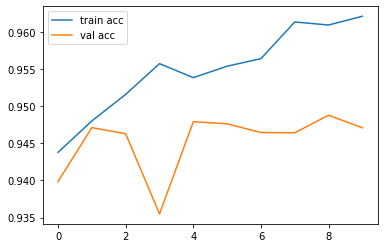

In [ ]:
diagnose_plots(history2)

In [ ]:
_, accuracy2 = model2.evaluate_generator(validation_generator, steps=30, verbose=0)
accuracy2

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


0.9605171084403992

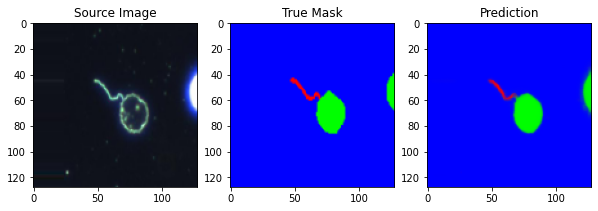

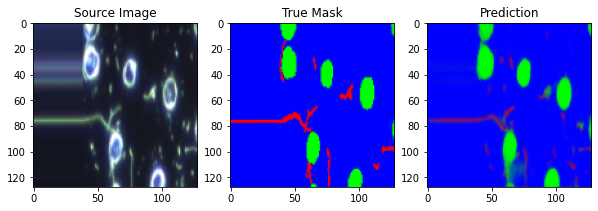

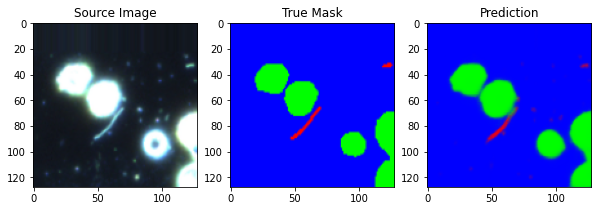

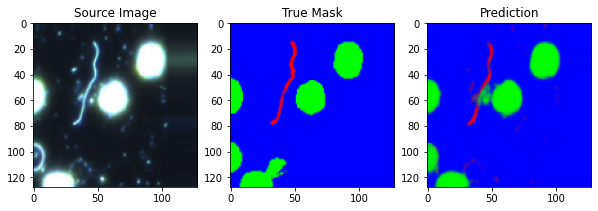

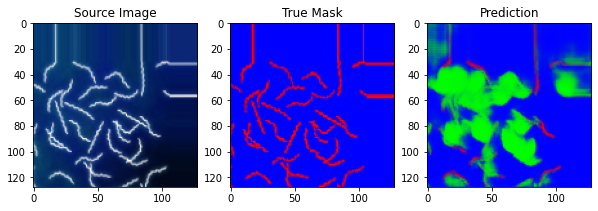

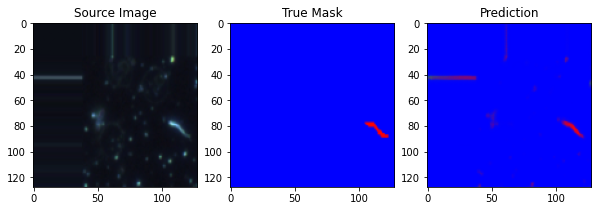

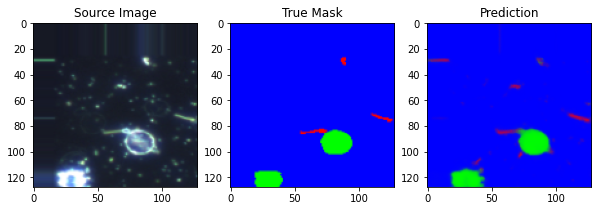

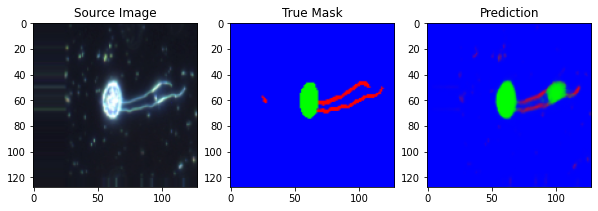

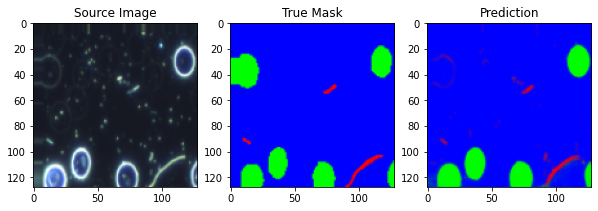

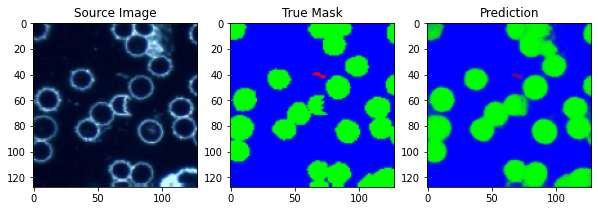

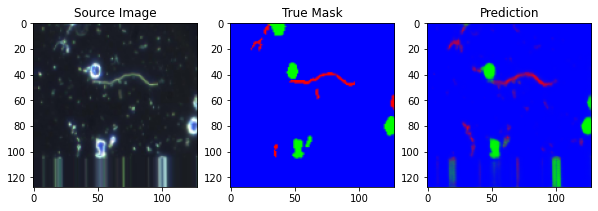

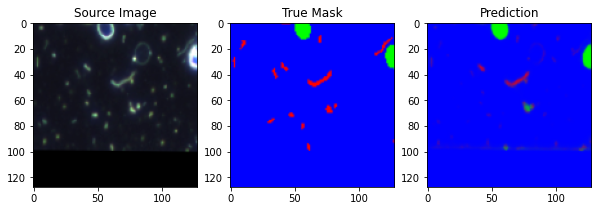

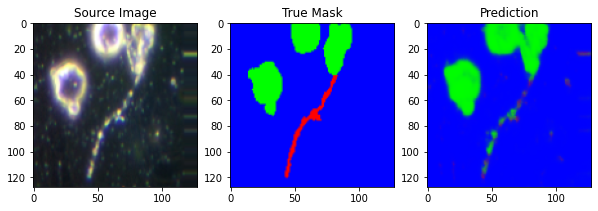

In [ ]:
testIMG, labels = validation_generator.__next__()
predictions = model2.predict(testIMG, use_multiprocessing=False)

for i in range(len(predictions)):
	
	figure = plt.figure(figsize=(10,10))

	plt.subplot(1,3,1)
	plt.title('Source Image')
	plt.imshow(testIMG[i] / 255)

	plt.subplot(1,3,2)
	plt.title('True Mask')
	plt.imshow(labels[i])


	plt.subplot(1,3,3)
	plt.title('Prediction')
	plt.imshow(predictions[i])

plt.show()




In [ ]:
# Third model with custom loss to handle imbalance


**Explanation of approach**
1. assigning each label_class an equal weight = 0
2. iterating over each image
3. counting the count of unique class_labels in every mask image
4. updating the weights dictonary with this count
5. updating the final weight by dividing the total count of label_classes by the count of the respective label_class


In [ ]:
# defining loss weights dictionary
_weights = {
    0: 0,
    1: 0,
    2:0
}

for masks in tqdm(os.listdir('/content/gdrive/MyDrive/BacteriaSegmentation/data/dataForModel/encodedMasks/encodedMasks')):
    mask = cv2.imread(os.path.join('/content/gdrive/MyDrive/BacteriaSegmentation/data/dataForModel/encodedMasks/encodedMasks', masks))
    label_class = tf.argmax(mask, axis=-1).numpy()
    label_class_num = np.unique(label_class, return_counts=True)
    
    for c in range(len(label_class_num[0])):
        _weights[label_class_num[0][c]] += label_class_num[1][c]

total = sum(_weights.values())
for k, v in _weights.items():
    _weights[k] = total / v
    
_weights

100%|██████████| 366/366 [00:11<00:00, 32.02it/s]


{0: 1.1641775925500915, 1: 7.671753279196013, 2: 93.6660646455102}

In [ ]:
weights_ = np.array([[[_weights[0], _weights[1], _weights[2]]] * IMG_WIDTH] * IMG_HEIGHT)

In [ ]:
model3 = tf.keras.Model(inputs=[inputs1], outputs=[outputs1])
model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'], loss_weights=weights_)
model3.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 128, 128, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 128, 128, 16) 448         lambda_1[0][0]                   
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, 128, 128, 16) 2320        conv2d_10[0][0]                  
____________________________________________________________________________________________

In [ ]:
# Uncomment to draw model graph

#tf.keras.utils.plot_model(model1, to_file='model3_new.png', show_shapes=True)

In [ ]:
history3 = model3.fit_generator(training_generator,
                          epochs=10,
                          steps_per_epoch = 100,
                          validation_data=validation_generator,
                          validation_steps=10)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
100/100 [==============================] - 44s 428ms/step - loss: 3.7258 - accuracy: 0.9625 - val_loss: 6.8086 - val_accuracy: 0.9471
Epoch 2/10
100/100 [==============================] - 42s 428ms/step - loss: 5.5725 - accuracy: 0.9534 - val_loss: 7.3442 - val_accuracy: 0.9475
Epoch 3/10
100/100 [==============================] - 42s 425ms/step - loss: 6.5906 - accuracy: 0.9510 - val_loss: 5.8979 - val_accuracy: 0.9557
Epoch 4/10
100/100 [==============================] - 42s 428ms/step - loss: 5.7851 - accuracy: 0.9540 - val_loss: 7.0156 - val_accuracy: 0.9453
Epoch 5/10
100/100 [==============================] - 42s 420ms/step - loss: 6.0048 - accuracy: 0.9516 - val_loss: 8.0665 - val_accuracy: 0.9430
Epoch 6/10
100/100 [==============================] - 42s 428ms/step - loss: 5.4459 - accuracy: 0.9562 - val_loss: 6.4675 - val_accuracy: 0.9517
Epoch 7/10
100/100 [==============================] - 42s 426ms/step - loss: 5.6998 - accuracy: 0.9539 - val_loss: 6.5193 - val_ac

In [ ]:
model3.save("saved_model/model3.h5")

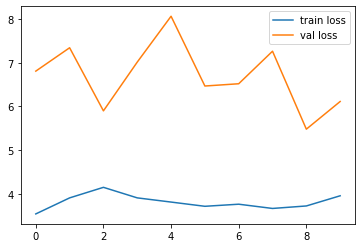

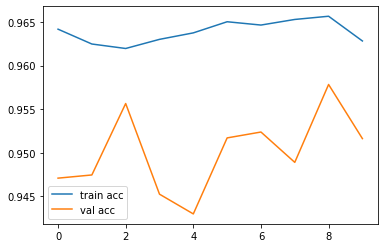

In [ ]:
diagnose_plots(history3)

In [ ]:
_, accuracy3 = model3.evaluate_generator(validation_generator, steps=30, verbose=0)
accuracy3

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


0.9623652100563049

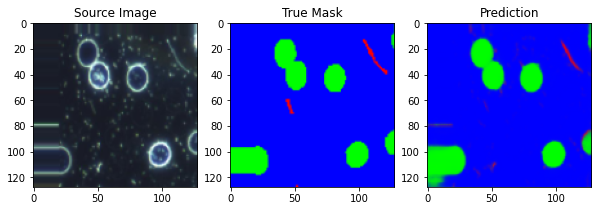

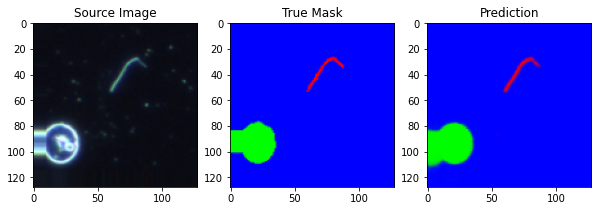

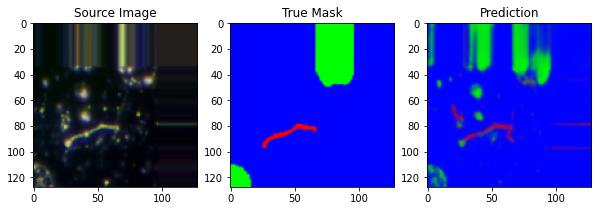

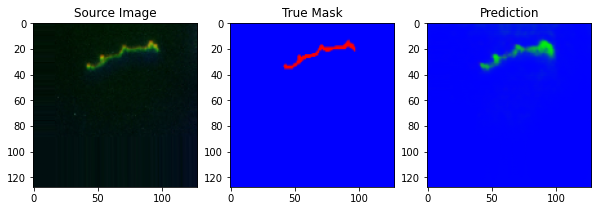

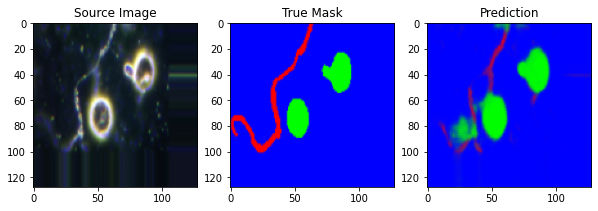

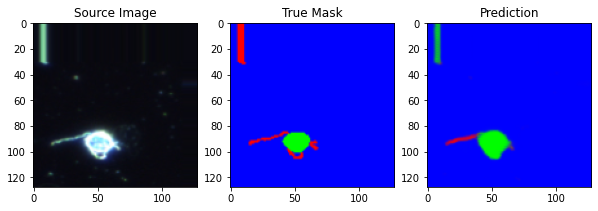

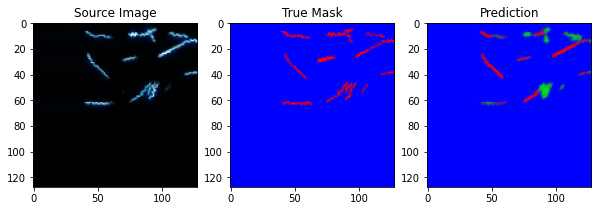

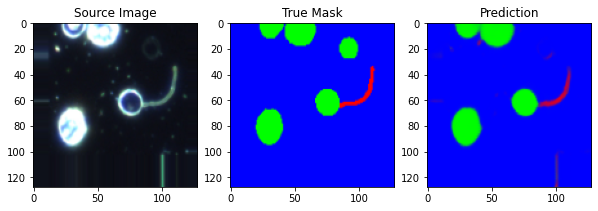

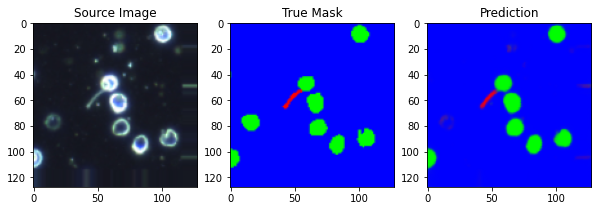

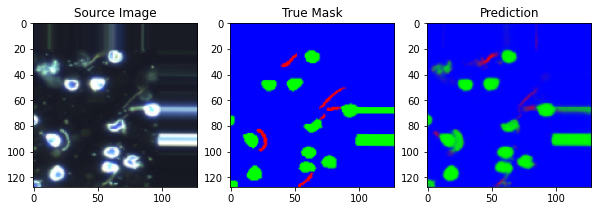

In [ ]:
testIMG, labels = validation_generator.__next__()
predictions = model3.predict(testIMG, use_multiprocessing=False)

for i in range(len(predictions)):
	
	figure = plt.figure(figsize=(10,10))

	plt.subplot(1,3,1)
	plt.title('Source Image')
	plt.imshow(testIMG[i] / 255)

	plt.subplot(1,3,2)
	plt.title('True Mask')
	plt.imshow(labels[i])


	plt.subplot(1,3,3)
	plt.title('Prediction')
	plt.imshow(predictions[i])

plt.show()




In [ ]:
# Fourth model with optimized structure and custom loss to handle imbalance

In [ ]:
# optimized architecture

inputs2 = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, CHANNELS))
x = tf.keras.layers.Lambda(lambda x: x / 255)(inputs2)

c1 = tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu')(x)
c1 = tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(p1)
c2 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

c3 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(p2)
c3 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

c4 = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(p3)
c4 = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(c4)
p4 = tf.keras.layers.MaxPooling2D((2, 2))(c4)

c5 = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(p4)
c5 = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(c5)

u6 = tf.keras.layers.UpSampling2D((2, 2))(c5)
u6 = tf.keras.layers.Concatenate()([c4, u6])

u7 = tf.keras.layers.Conv2DTranspose(256, (3, 3), padding='same', activation='relu')(u6)
u7 = tf.keras.layers.Conv2DTranspose(256, (3, 3), padding='same', activation='relu')(u7)
u7 = tf.keras.layers.UpSampling2D((2, 2))(u7)
u7 = tf.keras.layers.Concatenate()([c3, u7])

u8 = tf.keras.layers.Conv2DTranspose(128, (3, 3), padding='same', activation='relu')(u7)
u8 = tf.keras.layers.Conv2DTranspose(128, (3, 3), padding='same', activation='relu')(u8)
u8 = tf.keras.layers.UpSampling2D((2, 2))(u8)
u8 = tf.keras.layers.Concatenate()([c2, u8])

u9 = tf.keras.layers.Conv2DTranspose(64, (3, 3), padding='same', activation='relu')(u8)
u9 = tf.keras.layers.Conv2DTranspose(64, (3, 3), padding='same', activation='relu')(u9)
u9 = tf.keras.layers.UpSampling2D((2, 2))(u9)
u9 = tf.keras.layers.Concatenate()([c1, u9])

u10 = tf.keras.layers.Conv2DTranspose(32, (3, 3), padding='same', activation='relu')(u9)
u10 = tf.keras.layers.Conv2DTranspose(32, (3, 3), padding='same', activation='relu')(u10)
outputs2 = tf.keras.layers.Conv2DTranspose(3, (1, 1), activation='softmax')(u10)



In [ ]:
model4 = tf.keras.Model(inputs=[inputs2], outputs=[outputs2])
model4.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'], loss_weights=weights_)
model4.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 128, 128, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 32) 896         lambda[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 32) 9248        conv2d[0][0]                     
______________________________________________________________________________________________

In [ ]:
# Uncomment to draw model graph

#tf.keras.utils.plot_model(model4, to_file='model4_new.png', show_shapes=True)

In [ ]:
history4 = model4.fit(training_generator,
                          epochs = 20,
                          steps_per_epoch = 100,
                          validation_data = validation_generator,
                          validation_steps = 10)


Epoch 1/20
100/100 [==============================] - 52s 463ms/step - loss: 79.7481 - accuracy: 0.8059 - val_loss: 8.1369 - val_accuracy: 0.9285
Epoch 2/20
100/100 [==============================] - 43s 432ms/step - loss: 9.6275 - accuracy: 0.8979 - val_loss: 8.0703 - val_accuracy: 0.9330
Epoch 3/20
100/100 [==============================] - 43s 434ms/step - loss: 7.7687 - accuracy: 0.9203 - val_loss: 9.0664 - val_accuracy: 0.9095
Epoch 4/20
100/100 [==============================] - 43s 431ms/step - loss: 8.3059 - accuracy: 0.9178 - val_loss: 7.5339 - val_accuracy: 0.9306
Epoch 5/20
100/100 [==============================] - 44s 442ms/step - loss: 7.7757 - accuracy: 0.9270 - val_loss: 7.5942 - val_accuracy: 0.9315
Epoch 6/20
100/100 [==============================] - 43s 434ms/step - loss: 6.3823 - accuracy: 0.9401 - val_loss: 6.9040 - val_accuracy: 0.9404
Epoch 7/20
100/100 [==============================] - 43s 438ms/step - loss: 6.5375 - accuracy: 0.9432 - val_loss: 6.0669 - val_a

In [ ]:
model4.save("saved_model/model4.h5")

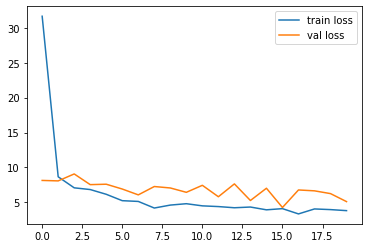

In [ ]:
diagnose_plots(history4)

In [ ]:
_, accuracy4 = model4.evaluate_generator(validation_generator, steps=30, verbose=0)
accuracy4

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


0.9643719792366028

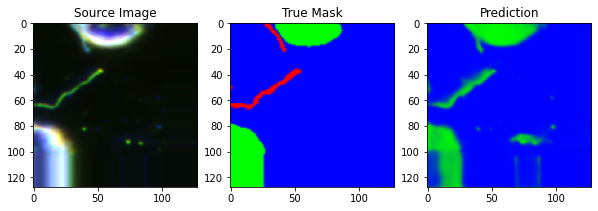

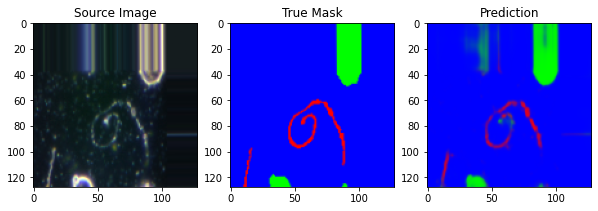

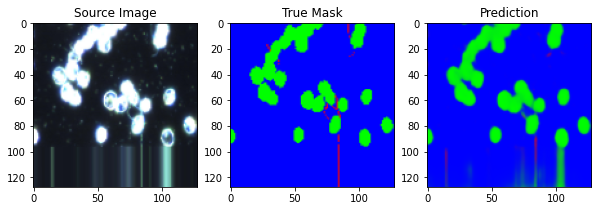

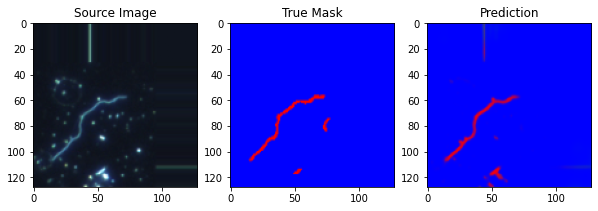

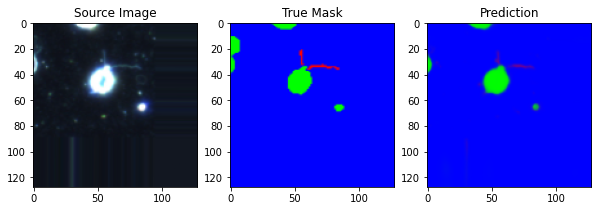

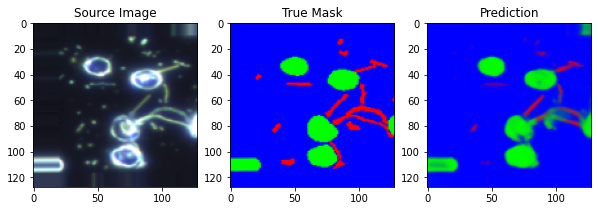

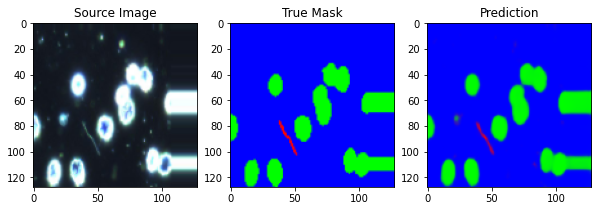

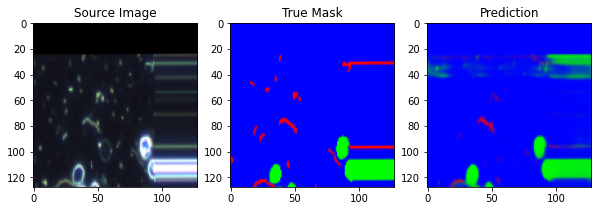

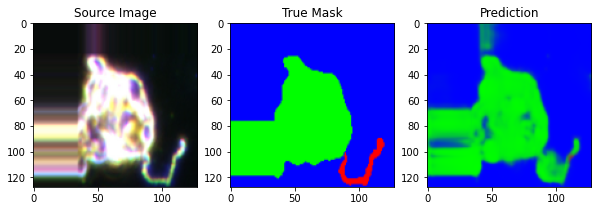

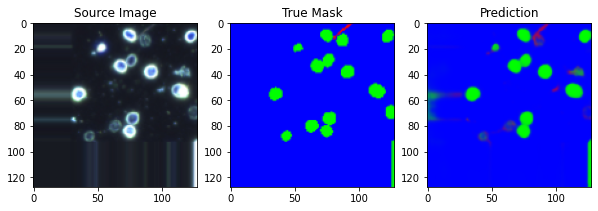

In [ ]:
testIMG, labels = validation_generator.__next__()
predictions = model4.predict(testIMG, use_multiprocessing=False)

for i in range(len(predictions)):
	
	figure = plt.figure(figsize=(10,10))

	plt.subplot(1,3,1)
	plt.title('Source Image')
	plt.imshow(testIMG[i] / 255)

	plt.subplot(1,3,2)
	plt.title('True Mask')
	plt.imshow(labels[i])


	plt.subplot(1,3,3)
	plt.title('Prediction')
	plt.imshow(predictions[i])

plt.show()




In [ ]:
# Compiling the results
models = ['Model1 with callbacks', 'Model2 without callbacks', 'Model3 with custom loss', "optimized architecture with custom loss"]
model_accuracy = [accuracy1*100, accuracy2*100, accuracy3*100, accuracy4*100]

data = [models, model_accuracy]
column_names = ['model', 'accuracy']

report = pd.DataFrame(np.column_stack(data), columns=column_names)

report

model           accuracy
0                    Model1 with callbacks  93.29489469528198
1                 Model2 without callbacks  96.05171084403992
2                  Model3 with custom loss   96.2365210056305
3  optimized architecture with custom loss  96.43719792366028